In [1]:
# Install dependencies 
!pip install transformers datasets accelerate --quiet

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
import random
import numpy as np
from tqdm import tqdm

# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load dataset splits
train_dataset_raw = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid_dataset_raw = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test_dataset_raw = load_dataset("tau/commonsense_qa", split="validation")

# Helper to convert one example to a prompt
def format_example(example, include_answer=False):
    prompt = f"Question: {example['question']}\n"
    for idx, choice in enumerate(example["choices"]["text"]):
        prompt += f"{chr(ord('A') + idx)}. {choice}\n"
    prompt += "Answer:"
    if include_answer:
        correct_idx = example["choices"]["label"].index(example["answerKey"])
        prompt += f" {chr(ord('A') + correct_idx)}"
    return prompt

# Example prompt
print(format_example(train_dataset_raw[0], include_answer=True))


Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A. ignore
B. enforce
C. authoritarian
D. yell at
E. avoid
Answer: A


100%|██████████| 1221/1221 [01:34<00:00, 12.94it/s]


Zero-shot accuracy on full test set: 85.83%


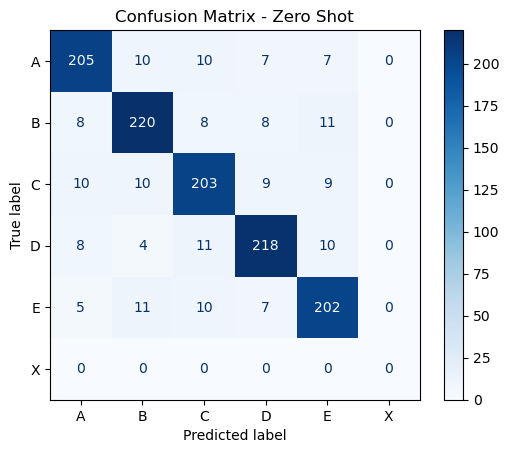

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def run_zero_shot_with_confmat(model, tokenizer, dataset):
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for example in tqdm(dataset):
        prompt = format_example(example, include_answer=False)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().upper()

        correct_ans = example["answerKey"]

        y_true.append(correct_ans)
        # Ensure we only take the first letter of prediction if valid
        y_pred.append(pred[0] if pred and pred[0] in "ABCDE" else "X")  # X for invalid/unmapped

        if pred.startswith(correct_ans):
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Zero-shot accuracy on full test set: {accuracy:.2%}")

    # Plot confusion matrix
    labels = ["A", "B", "C", "D", "E", "X"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Zero Shot")
    plt.show()

    return accuracy
zero_shot_accuracy = run_zero_shot_with_confmat(model, tokenizer, test_dataset_raw)


100%|██████████| 1221/1221 [01:55<00:00, 10.57it/s]


Few-shot accuracy on full test set: 85.09%


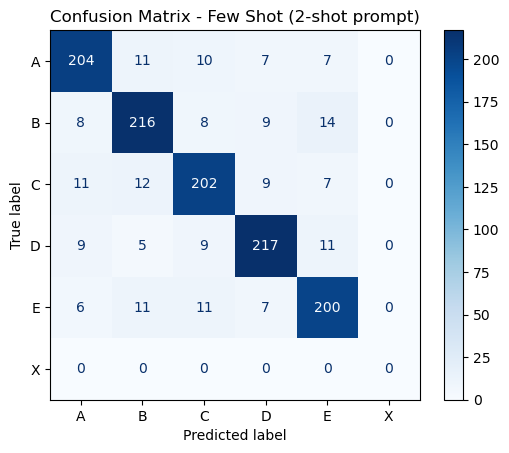

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Select a few fixed examples for few-shot prompting
few_shot_examples = [train_dataset_raw[i] for i in [1, 5]]

# Format prompt with few-shot context + one new question
def format_few_shot_prompt(target_example, examples):
    prompt = ""
    for ex in examples:
        prompt += format_example(ex, include_answer=True) + "\n\n"
    prompt += format_example(target_example, include_answer=False)
    return prompt

# Few-shot evaluation with confusion matrix
def run_few_shot_with_confmat(model, tokenizer, dataset, few_shot_examples, debug=False):
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for i, example in enumerate(tqdm(dataset)):
        prompt = format_few_shot_prompt(example, few_shot_examples)
        if debug and i == 0:
            print("\n--- Sample Prompt ---\n")
            print(prompt)

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().upper()

        if debug:
            print(f"Prediction: {pred} | Ground Truth: {example['answerKey']}")

        correct_ans = example["answerKey"]
        y_true.append(correct_ans)
        y_pred.append(pred[0] if pred and pred[0] in "ABCDE" else "X")  # "X" for invalid output

        if pred.startswith(correct_ans):
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Few-shot accuracy on full test set: {accuracy:.2%}")

    # Plot confusion matrix
    labels = ["A", "B", "C", "D", "E", "X"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Few Shot (2-shot prompt)")
    plt.show()

    return accuracy

# Run on full test set now
few_shot_accuracy = run_few_shot_with_confmat(model, tokenizer, test_dataset_raw, few_shot_examples)

In [6]:
# Few-shot examples with CoT reasoning
few_shot_cot_examples = [
    """Question: Though it stayed strictly indoors, the small dog felt like it had all the space in the world in the what?
A. living room
B. dog park
C. basket
D. small apartment
E. big house
Answer: Let's think step by step. Since the dog is strictly indoors, options like the dog park are invalid. A small apartment or basket wouldn’t feel spacious. A big house, despite being indoors, would feel spacious to the dog. So the answer is E""",

    """Question: The priest pushed for more orthodox behavior, what kind of behavior was he trying to stop?
A. liberal
B. heretical
C. recalcitrant
D. conservadox
E. heretical
Answer: Let's think step by step. Orthodox behavior means conforming to traditional beliefs. The opposite of that is heretical behavior, which goes against religious doctrine. So the answer is B""",

    """Question: A person writes a check to a clerk, where does the clerk put them?
A. cash register
B. desk drawer
C. pay envelope
D. throw away
E. box
Answer: Let's think step by step. A check is a form of payment. Clerks usually store payments in the cash register. So the answer is A""",

    """Question: The small cabin was not available, so they were upgraded to what?
A. villa
B. spacecraft
C. hall
D. palace
E. hotel
Answer: Let's think step by step. If a small cabin is unavailable, an upgrade would mean something larger and more luxurious. A villa is a common upgrade option in vacation contexts. So the answer is A"""
]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def run_zero_shot_cot(model, tokenizer, dataset):
    y_true = []
    y_pred = []
    label_list = ["A", "B", "C", "D", "E"]

    for example in tqdm(dataset):
        # CoT prompt
        prompt = f"Question: {example['question']}\n"
        for idx, choice in enumerate(example["choices"]["text"]):
            prompt += f"{chr(ord('A') + idx)}. {choice}\n"
        prompt += "Answer: Let's think step by step."

        # Generate prediction
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=32)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        # Extract answer (first label A-E found)
        pred_label = "Z"
        for label in label_list:
            if pred.upper().startswith(label):
                pred_label = label
                break

        y_true.append(example["answerKey"])
        y_pred.append(pred_label)

    # Accuracy
    correct = sum(p == t for p, t in zip(y_pred, y_true))
    accuracy = correct / len(y_true)
    print(f"\nZero-Shot CoT Accuracy on Test Set: {accuracy:.2%}")

    # Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=label_list))

    cm = confusion_matrix(y_true, y_pred, labels=label_list)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Zero-Shot CoT")
    plt.show()
run_zero_shot_cot(model, tokenizer, test_dataset_raw)

In [ ]:
def format_cot_prompt(example, few_shot_examples):
    prompt = "\n\n".join(few_shot_examples) + "\n\n"
    prompt += f"Question: {example['question']}\n"
    for idx, choice in enumerate(example["choices"]["text"]):
        prompt += f"{chr(ord('A') + idx)}. {choice}\n"
    prompt += "Answer: Let's think step by step."
    return prompt

def run_few_shot_cot_with_confmat(model, tokenizer, dataset, few_shot_examples, debug=False):
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for i, example in enumerate(tqdm(dataset)):
        prompt = format_cot_prompt(example, few_shot_examples)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=64)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().upper()

        if debug and i == 0:
            print("\n--- Sample Prompt ---\n")
            print(prompt)
            print(f"\n--- Model Output ---\n{pred}\n")

        # Extract label: either first valid A-E token, or fall back to "Z"
        pred_label = "Z"
        for letter in ["A", "B", "C", "D", "E"]:
            if pred.startswith(letter):
                pred_label = letter
                break
            if f"answer is {letter}" in pred:
                pred_label = letter
                break

        correct_label = example["answerKey"]
        y_true.append(correct_label)
        y_pred.append(pred_label)

        if pred_label == correct_label:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"Few-shot Chain-of-Thought accuracy on full test set: {accuracy:.2%}")

    # Plot confusion matrix
    labels = ["A", "B", "C", "D", "E", "Z"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Few Shot Chain-of-Thought")
    plt.show()

    return accuracy

few_shot_cot_accuracy = run_few_shot_cot_with_confmat(model, tokenizer, test_dataset_raw, few_shot_cot_examples)


 23%|██▎       | 284/1221 [04:16<14:01,  1.11it/s]

In [3]:
def run_zero_shot(model, tokenizer, dataset, max_samples=100):
    correct = 0
    total = 0
    for example in tqdm(dataset.select(range(max_samples))):
        prompt = format_example(example, include_answer=False)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        # Ground truth
        correct_ans = example["answerKey"]
        if pred.upper().startswith(correct_ans):
            correct += 1
        total += 1
    return correct / total

zero_shot_accuracy = run_zero_shot(model, tokenizer, valid_dataset_raw, max_samples=100)
print(f"Zero-shot accuracy: {zero_shot_accuracy:.2%}")


100%|██████████| 100/100 [00:08<00:00, 11.44it/s]

Zero-shot accuracy: 97.00%


In [4]:
def run_zero_shot(model, tokenizer, dataset):
    correct = 0
    total = 0
    for example in tqdm(dataset):
        prompt = format_example(example, include_answer=False)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        correct_ans = example["answerKey"]
        if pred.upper().startswith(correct_ans):
            correct += 1
        total += 1
    return correct / total

# Run on full test set now
zero_shot_accuracy = run_zero_shot(model, tokenizer, test_dataset_raw)
print(f"Zero-shot accuracy on full test set: {zero_shot_accuracy:.2%}")


100%|██████████| 1221/1221 [01:34<00:00, 12.98it/s]

Zero-shot accuracy on full test set: 85.83%


In [5]:
# Select a few fixed examples for few-shot prompting
few_shot_examples = [train_dataset_raw[i] for i in [1, 5]]  
# Format prompt with few-shot context + one new question
def format_few_shot_prompt(target_example, examples):
    prompt = ""
    for ex in examples:
        prompt += format_example(ex, include_answer=True) + "\n\n"
    prompt += format_example(target_example, include_answer=False)
    return prompt

# Few-shot evaluation
def run_few_shot(model, tokenizer, dataset, few_shot_examples, max_samples=100, debug=False):
    correct = 0
    total = 0
    for i, example in enumerate(tqdm(dataset.select(range(max_samples)))):
        prompt = format_few_shot_prompt(example, few_shot_examples)
        if debug and i == 0:
            print("\n--- Sample Prompt ---\n")
            print(prompt)

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        if debug:
            print(f"Prediction: {pred} | Ground Truth: {example['answerKey']}")

        if pred.upper().startswith(example["answerKey"]):
            correct += 1
        total += 1
    return correct / total

# Run few-shot evaluation on validation set
few_shot_accuracy = run_few_shot(model, tokenizer, valid_dataset_raw, few_shot_examples, max_samples=100, debug=True)
print(f"Few-shot accuracy (with 2-shot prompt): {few_shot_accuracy:.2%}")


  0%|          | 0/100 [00:00<?, ?it/s]


--- Sample Prompt ---

Question: Sammy wanted to go to where the people were.  Where might he go?
A. race track
B. populated areas
C. the desert
D. apartment
E. roadblock
Answer: B

Question: What home entertainment equipment requires cable?
A. radio shack
B. substation
C. cabinet
D. television
E. desk
Answer: D

Question: What is a well known way for couples  of celebrating a marriage?
A. eat cake
B. getting drunk
C. having sex
D. cleaning rooms
E. drink too much
Answer:


  3%|▎         | 3/100 [00:00<00:14,  6.59it/s]

Prediction: C | Ground Truth: C
Prediction: B | Ground Truth: B
Prediction: A | Ground Truth: A


  5%|▌         | 5/100 [00:00<00:11,  8.15it/s]

Prediction: D | Ground Truth: D
Prediction: D | Ground Truth: D
Prediction: B | Ground Truth: B


  9%|▉         | 9/100 [00:01<00:09,  9.53it/s]

Prediction: A | Ground Truth: A
Prediction: E | Ground Truth: E
Prediction: A | Ground Truth: A


 11%|█         | 11/100 [00:01<00:09,  9.88it/s]

Prediction: B | Ground Truth: B
Prediction: B | Ground Truth: B
Prediction: D | Ground Truth: D


 15%|█▌        | 15/100 [00:01<00:08, 10.21it/s]

Prediction: A | Ground Truth: A
Prediction: B | Ground Truth: B
Prediction: C | Ground Truth: C


 17%|█▋        | 17/100 [00:01<00:08, 10.33it/s]

Prediction: C | Ground Truth: C
Prediction: E | Ground Truth: E
Prediction: C | Ground Truth: C


 21%|██        | 21/100 [00:02<00:07, 10.45it/s]

Prediction: A | Ground Truth: A
Prediction: D | Ground Truth: D
Prediction: A | Ground Truth: A


 23%|██▎       | 23/100 [00:02<00:07, 10.49it/s]

Prediction: C | Ground Truth: C
Prediction: B | Ground Truth: B
Prediction: D | Ground Truth: D


 27%|██▋       | 27/100 [00:02<00:06, 10.56it/s]

Prediction: D | Ground Truth: B
Prediction: B | Ground Truth: B
Prediction: E | Ground Truth: E


 29%|██▉       | 29/100 [00:02<00:06, 10.56it/s]

Prediction: C | Ground Truth: C
Prediction: E | Ground Truth: E
Prediction: B | Ground Truth: B


 31%|███       | 31/100 [00:03<00:06, 10.57it/s]

Prediction: E | Ground Truth: E
Prediction: B | Ground Truth: B


 35%|███▌      | 35/100 [00:03<00:06, 10.36it/s]

Prediction: B | Ground Truth: B
Prediction: B | Ground Truth: B
Prediction: A | Ground Truth: A


 37%|███▋      | 37/100 [00:03<00:06, 10.43it/s]

Prediction: C | Ground Truth: C
Prediction: A | Ground Truth: A
Prediction: B | Ground Truth: B


 41%|████      | 41/100 [00:04<00:05, 10.55it/s]

Prediction: E | Ground Truth: E
Prediction: D | Ground Truth: D
Prediction: C | Ground Truth: C


 43%|████▎     | 43/100 [00:04<00:05, 10.56it/s]

Prediction: D | Ground Truth: D
Prediction: C | Ground Truth: C
Prediction: E | Ground Truth: E


 45%|████▌     | 45/100 [00:04<00:05, 10.56it/s]

Prediction: C | Ground Truth: C
Prediction: E | Ground Truth: E


 47%|████▋     | 47/100 [00:04<00:05, 10.28it/s]

Prediction: E | Ground Truth: E
Prediction: C | Ground Truth: C


 51%|█████     | 51/100 [00:05<00:04, 10.24it/s]

Prediction: E | Ground Truth: E
Prediction: C | Ground Truth: C
Prediction: A | Ground Truth: A


 53%|█████▎    | 53/100 [00:05<00:04, 10.33it/s]

Prediction: E | Ground Truth: E
Prediction: E | Ground Truth: D
Prediction: E | Ground Truth: E


 57%|█████▋    | 57/100 [00:05<00:04, 10.47it/s]

Prediction: E | Ground Truth: E
Prediction: E | Ground Truth: E
Prediction: E | Ground Truth: E


 59%|█████▉    | 59/100 [00:05<00:03, 10.43it/s]

Prediction: D | Ground Truth: D
Prediction: A | Ground Truth: A
Prediction: D | Ground Truth: D


 61%|██████    | 61/100 [00:06<00:03, 10.48it/s]

Prediction: D | Ground Truth: D
Prediction: A | Ground Truth: A


 65%|██████▌   | 65/100 [00:06<00:03, 10.32it/s]

Prediction: D | Ground Truth: D
Prediction: B | Ground Truth: B
Prediction: B | Ground Truth: B


 67%|██████▋   | 67/100 [00:06<00:03, 10.38it/s]

Prediction: A | Ground Truth: A
Prediction: C | Ground Truth: C
Prediction: E | Ground Truth: E


 71%|███████   | 71/100 [00:07<00:02, 10.51it/s]

Prediction: E | Ground Truth: E
Prediction: E | Ground Truth: E
Prediction: A | Ground Truth: A


 73%|███████▎  | 73/100 [00:07<00:02, 10.56it/s]

Prediction: B | Ground Truth: B
Prediction: C | Ground Truth: C


 75%|███████▌  | 75/100 [00:07<00:02, 10.30it/s]

Prediction: E | Ground Truth: E
Prediction: D | Ground Truth: D
Prediction: B | Ground Truth: B


 77%|███████▋  | 77/100 [00:07<00:02, 10.40it/s]

Prediction: B | Ground Truth: B
Prediction: D | Ground Truth: D


 81%|████████  | 81/100 [00:07<00:01, 10.29it/s]

Prediction: E | Ground Truth: E
Prediction: B | Ground Truth: B
Prediction: D | Ground Truth: D


 83%|████████▎ | 83/100 [00:08<00:01, 10.38it/s]

Prediction: B | Ground Truth: B
Prediction: B | Ground Truth: B
Prediction: A | Ground Truth: A


 87%|████████▋ | 87/100 [00:08<00:01, 10.49it/s]

Prediction: B | Ground Truth: B
Prediction: B | Ground Truth: B
Prediction: E | Ground Truth: E


 89%|████████▉ | 89/100 [00:08<00:01, 10.45it/s]

Prediction: D | Ground Truth: D
Prediction: D | Ground Truth: D


 91%|█████████ | 91/100 [00:08<00:00, 10.21it/s]

Prediction: A | Ground Truth: A
Prediction: D | Ground Truth: D
Prediction: E | Ground Truth: E


 95%|█████████▌| 95/100 [00:09<00:00, 10.19it/s]

Prediction: A | Ground Truth: B
Prediction: D | Ground Truth: D
Prediction: C | Ground Truth: C


 97%|█████████▋| 97/100 [00:09<00:00, 10.29it/s]

Prediction: D | Ground Truth: D
Prediction: C | Ground Truth: C
Prediction: D | Ground Truth: D


100%|██████████| 100/100 [00:09<00:00, 10.18it/s]

Prediction: A | Ground Truth: A
Prediction: E | Ground Truth: E
Few-shot accuracy (with 2-shot prompt): 97.00%


In [6]:
def run_few_shot_test(model, tokenizer, dataset, few_shot_examples, max_samples=None):
    correct = 0
    total = 0
    if max_samples is None:
        data_iter = dataset
    else:
        data_iter = dataset.select(range(max_samples))
    for example in tqdm(data_iter):
        prompt = format_few_shot_prompt(example, few_shot_examples)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=2)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        if pred.upper().startswith(example["answerKey"]):
            correct += 1
        total += 1
    return correct / total

# Run few-shot evaluation on the test set (full or limited)
few_shot_accuracy_test = run_few_shot_test(model, tokenizer, test_dataset_raw, few_shot_examples)
print(f"Few-shot accuracy on test set: {few_shot_accuracy_test:.2%}")

100%|██████████| 1221/1221 [01:56<00:00, 10.51it/s]

Few-shot accuracy on test set: 85.09%


In [3]:
print(format_example(train_dataset_raw[0], include_answer=True))

Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A. ignore
B. enforce
C. authoritarian
D. yell at
E. avoid
Answer: A


In [5]:
print(format_example(train_dataset_raw[3], include_answer=True))

Question: Google Maps and other highway and street GPS services have replaced what?
A. united states
B. mexico
C. countryside
D. atlas
E. oceans
Answer: D


In [6]:
print(format_example(train_dataset_raw[6], include_answer=True))

Question: The only baggage the woman checked was a drawstring bag, where was she heading with it?
A. garbage can
B. military
C. jewelry store
D. safe
E. airport
Answer: E


In [8]:
print(format_example(train_dataset_raw[9], include_answer=True))

Question: Where is a business restaurant likely to be located?
A. town
B. at hotel
C. mall
D. business sector
E. yellow pages
Answer: D


In [9]:
print(format_example(train_dataset_raw[22], include_answer=True))

Question: You can share files with someone if you have a connection to a what?
A. freeway
B. radio
C. wires
D. computer network
E. electrical circuit
Answer: D


In [10]:
print(format_example(train_dataset_raw[111], include_answer=True))

Question: Though it stayed strictly indoors, the small dog felt like it had all the space in the world in the what?
A. living room
B. dog park
C. basket
D. small apartment
E. big house
Answer: E


In [11]:
print(format_example(train_dataset_raw[222], include_answer=True))

Question: What emotion do people expressing themselves show when they trip in front of a crowd and break their leg?
A. communication
B. suffering
C. pain
D. laughter
E. embarrassment
Answer: E


In [12]:
print(format_example(train_dataset_raw[333], include_answer=True))

Question: The priest pushed for more orthodox behavior, what kind of behavior was he trying to stop?
A. liberal
B. heretical
C. recalcitrant
D. conservadox
E. heretical
Answer: B


In [13]:
print(format_example(train_dataset_raw[444], include_answer=True))

Question: A person writes a check to a clerk, where does the clerk put them?
A. cash register
B. desk drawer
C. pay envelope
D. throw away
E. box
Answer: A


In [14]:
print(format_example(train_dataset_raw[555], include_answer=True))

Question: The small cabin was not available, so they were upgraded to what?
A. villa
B. spacecraft
C. hall
D. palace
E. hotel
Answer: A


In [15]:
# Few-shot examples with CoT reasoning
few_shot_cot_examples = [
    """Question: Though it stayed strictly indoors, the small dog felt like it had all the space in the world in the what?
A. living room
B. dog park
C. basket
D. small apartment
E. big house
Answer: Let's think step by step. Since the dog is strictly indoors, options like the dog park are invalid. A small apartment or basket wouldn’t feel spacious. A big house, despite being indoors, would feel spacious to the dog. So the answer is E""",

    """Question: The priest pushed for more orthodox behavior, what kind of behavior was he trying to stop?
A. liberal
B. heretical
C. recalcitrant
D. conservadox
E. heretical
Answer: Let's think step by step. Orthodox behavior means conforming to traditional beliefs. The opposite of that is heretical behavior, which goes against religious doctrine. So the answer is B""",

    """Question: A person writes a check to a clerk, where does the clerk put them?
A. cash register
B. desk drawer
C. pay envelope
D. throw away
E. box
Answer: Let's think step by step. A check is a form of payment. Clerks usually store payments in the cash register. So the answer is A""",

    """Question: The small cabin was not available, so they were upgraded to what?
A. villa
B. spacecraft
C. hall
D. palace
E. hotel
Answer: Let's think step by step. If a small cabin is unavailable, an upgrade would mean something larger and more luxurious. A villa is a common upgrade option in vacation contexts. So the answer is A"""
]


In [16]:
def format_cot_prompt(example, few_shot_examples):
    # Join the few-shot examples and append the target example without answer
    prompt = "\n\n".join(few_shot_examples) + "\n\n"
    prompt += f"Question: {example['question']}\n"
    for idx, choice in enumerate(example["choices"]["text"]):
        prompt += f"{chr(ord('A') + idx)}. {choice}\n"
    prompt += "Answer: Let's think step by step."
    return prompt

def run_few_shot_cot(model, tokenizer, dataset, few_shot_examples, max_samples=None):
    correct = 0
    total = 0
    eval_dataset = dataset.select(range(max_samples)) if max_samples else dataset

    for example in tqdm(eval_dataset):
        prompt = format_cot_prompt(example, few_shot_examples)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=32)
        pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        # Extract first valid label (A-E) from prediction
        for letter in ["A", "B", "C", "D", "E"]:
            if pred.upper().startswith(letter):
                pred_label = letter
                break
        else:
            pred_label = "Z"  # invalid prediction

        correct_label = example["answerKey"]
        if pred_label == correct_label:
            correct += 1
        total += 1

    return correct / total


In [17]:
# Evaluate on full test set with few-shot CoT
few_shot_cot_accuracy = run_few_shot_cot(model, tokenizer, test_dataset_raw, few_shot_cot_examples)
print(f"Few-shot CoT accuracy on full test set: {few_shot_cot_accuracy:.2%}")

100%|██████████| 1221/1221 [17:14<00:00,  1.18it/s]

Few-shot CoT accuracy on full test set: 69.53%
